# Water Quality, Perception and Knowledge in China: *Data Analysis (condensed)*

More information about the thesis, motivation, and methodology is located in the main "thesis_analysis.ipynb" document.

## Load Data

Load Python libraries

In [274]:
import pandas as pd
from pandas import DataFrame
import numpy as np # for some regression visualizations
import matplotlib as mpl
import seaborn as sns # for plots
import statsmodels.api as sm # for statistical analysis
import statsmodels.formula.api as smf # for statistical analysis
from sklearn import preprocessing # for normalizing data

In [35]:
# Returns ALL columns when displaying DataFrame, useful for finding column names
pd.set_option('display.max_columns', None)

Load CGSS (social survey) data from a Stata file

In [36]:
cgss = pd.read_stata('../data/cgss2010_12.dta', preserve_dtypes = True, convert_categoricals=False)

List categorical data

In [37]:
categoricals = ["s41","a2","a91","l1a","l1b","l7a","l7b","l2409"]

List important questions

In [38]:
important = ['score','s41','a2','a3a','a7a','a8a','a91','l1a','l1b','l6a','l7a','l7b','l8a','l8b','l137','l14d','l15a','l15b','l16c','l20e','l2409','province','province_en']

Convert categorical data into categorical data types

In [39]:
cgss[categoricals].astype('category')

s41 a2  a91  l1a  l1b   l7a   l7b l2409
0      28.0  2  1.0  NaN  NaN   NaN   NaN   NaN
1      28.0  2  1.0  NaN  NaN   NaN   NaN   NaN
2      28.0  2  2.0  NaN  NaN   NaN   NaN   NaN
3      28.0  2  2.0  8.0  2.0  98.0  98.0   8.0
4      28.0  1  2.0  NaN  NaN   NaN   NaN   NaN
...     ... ..  ...  ...  ...   ...   ...   ...
11778   1.0  1  2.0  NaN  NaN   NaN   NaN   NaN
11779   1.0  1  2.0  NaN  NaN   NaN   NaN   NaN
11780   1.0  1  2.0  NaN  NaN   NaN   NaN   NaN
11781   1.0  1  2.0  2.0  4.0  10.0  98.0   8.0
11782   1.0  1  2.0  9.0  9.0  10.0   2.0   2.0

[11783 rows x 8 columns]

Load province data from a .csv, set province code as the index

In [40]:
provinces = pd.read_csv('prov.csv')

Load water quality data

In [41]:
wqir = pd.read_csv('../data/wqir2018_zh.csv', sep=' ', encoding = "UTF-8")

---

## Merge data into one dataframe

Group the water quality data (WQIR) by province and compute the mean

In [42]:
wqir_mean = wqir.groupby(by='province').agg('mean')

Merge the mean water quality per province and the province dataframe (matching names and province codes)

In [43]:
merge = pd.merge(wqir_mean, provinces, on='province')

Drop rank column, merge the previously merged column into the main cgss dataframe so that each entry has the mean water score from their province, plus the names of their province (Chinese short and full and English).

In [51]:
wq = merge[['s41','score','province','province_full','province_en']]
cgss_wq_full = pd.merge(cgss,wq,on='s41')

Only analyze important questions and variables (drop remaining ones)

In [45]:
cgss_wq = cgss_wq_full[important]

---

## Testing Hypotheses (Descriptive Analysis)

### H1 - Worse local (provincial) water quality (`score` increases) relates to an increased perception of severity of water quality issues (`l14d` decreases).

First, clean the data for `l14d` by dropping NaN, negative and "cannot answer" values:

In [318]:
cgss_wq_l14d = cgss_wq[cgss_wq["l14d"]>0]
cgss_wq_l14d = cgss_wq_l14d[cgss_wq_l14d["l14d"]<6]

See distribution of responses for water quality score (left) and `l14d` (right).

array([[<AxesSubplot:title={'center':'score'}>,
        <AxesSubplot:title={'center':'l14d'}>]], dtype=object)

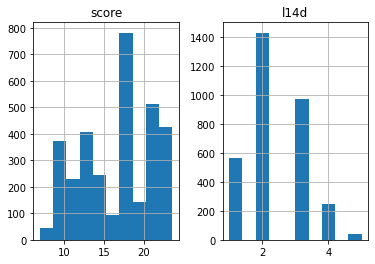

In [117]:
cgss_wq_l14d[["score","l14d"]].hist()

Visualize the results: Perception vs. Water Quality (more details about sns.lmplot in the Hypothesis 4 section)

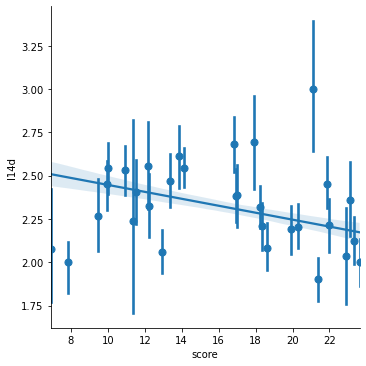

In [315]:
sns.lmplot(
    data=cgss_wq_l14d,
    x = 'score',
    y = 'l14d',
    x_estimator=np.mean,
    )

#### Initial findings:
- lmplot indicates a correlation, but it doesn't look right. Investigate...

### H2 - An increase knowledge of water quality issues (`l2409`) relates to an increased perception of severity (`l14d`).

### H3 - Increased education (`a7a`) relates to more knowledge about water quality (`l2409`).


### H4 - Increased education (`a7a`) relates to an increased perception of severity (`l14d`):

First, see the distribution of education:

array([[<AxesSubplot:title={'center':'a7a'}>,
        <AxesSubplot:title={'center':'l14d'}>]], dtype=object)

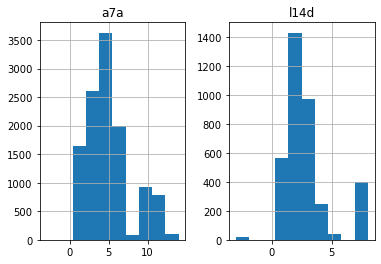

In [48]:
cgss_wq[["a7a","l14d"]].hist()

Make new cleaned dataset with cleaned `a7a` values from the previously cleaned `l14d` values

In [243]:
cgss_wq_l14d_a7a = cgss_wq_l14d[cgss_wq_l14d['a7a']>=0]

Group by each education level (year) and aggregate the mean

In [263]:
h4 = cgss_wq_l14d_a7a.groupby('a7a').agg('mean')

Plot result (perception vs. education level). 

**Note**: Since `a7a` is the index of h4, it needs to be reset before being plotted in regplot (info [here](https://www.reddit.com/r/learnpython/comments/3cjnpg/seaborn_xaxis_as_index/))

<AxesSubplot:xlabel='a7a', ylabel='l14d'>

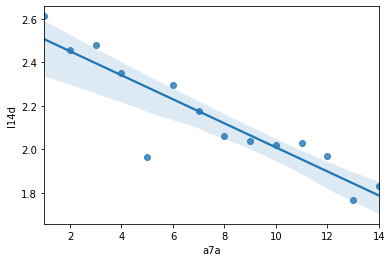

In [272]:
sns.regplot(
    data=h4.reset_index(),
    x = 'a7a',
    y = 'l14d'
    )

It's better (?) to use an lmplot (similar to regplot) and calculate the mean per x bin, from [here](https://seaborn.pydata.org/tutorial/regression.html).
> A second option is to collapse over the observations in each discrete bin to plot an estimate of central tendency along with a confidence interval:

Additionally, the lmplot allows for multiple regressions to be plotted on the same plot.

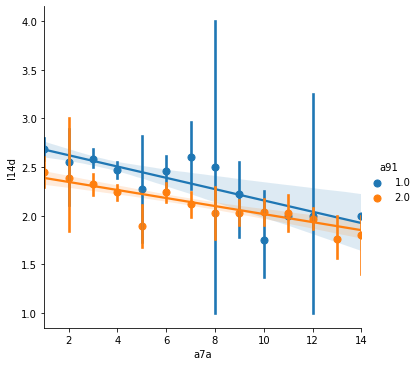

In [317]:
sns.lmplot(
    data=cgss_wq_l14d_a7a,
    x = 'a7a',
    y = 'l14d',
    x_estimator=np.mean,
    hue='a91'
    # col = 'a91'
    )

### Initial findings:
- There is a clear trend between education and perception
- Rural households have a higher `l14d` than non-rural at each education level
    - This difference decreases as education increases

### H5 - Rural households have an increased perception of severity of water quality issues than urban households.

Reuse the cleaned data from `H1` for question `l14d`, see number of responses by type by grouping by `a91`, where a91==1 is rural

In [206]:
cgss_wq_l14d[['a91','l14d']].groupby('a91').agg('count')

l14d
a91      
1.0  1257
2.0  1995

Calculate the mean `l14d` grouped by rural / urban

In [207]:
h5 = cgss_wq_l14d.groupby('a91').agg('mean')
h5

score        s41        a2          a3a       a7a          a8a  \
a91                                                                       
1.0  16.028347  16.902147  1.508353  1963.584726  3.479714  1051191.500   
2.0  17.060171  14.374436  1.524311  1962.532331  6.238596  1622341.125   

          l1a        l1b       l6a        l7a        l7b       l8a       l8b  \
a91                                                                            
1.0  9.197295  10.362768  3.617343  12.665871  12.211615  2.710422  2.401750   
2.0  7.379449   8.115288  3.815038   9.243108   9.663659  3.027068  2.653133   

         l137      l14d      l15a      l15b      l16c      l20e     l2409  
a91                                                                        
1.0  3.642005  2.536197  3.121718  3.120127  3.466985  2.669053  6.357995  
2.0  3.842105  2.172431  2.950376  2.893734  3.099248  2.309774  6.121805

#### Initial findings: 
- There is a difference between rural and urban households (rural have less severe perception of water quality)
- Education level (`a7a`) is significantly different between urban and rural households

---

## Normalize Data

First, start with `l2409`: Drop NAN, negative and `8` ("cannot answer)

In [46]:
cgss_wq_l2409 = cgss_wq[important][cgss_wq["l2409"]>0]
cgss_wq_l2409 = cgss_wq[cgss_wq["l2409"]<3]
cgss_wq_l2409

score   s41  a2   a3a  a7a       a8a  a91   l1a   l1b  l6a  l7a  l7b  \
44     13.84  28.0   1  1980    3    6000.0  2.0   2.0   6.0  5.0  3.0  3.0   
57     13.84  28.0   1  1966    1    2000.0  2.0  98.0  98.0  2.0  4.0  4.0   
102    13.84  28.0   2  1952    1       0.0  2.0   6.0   4.0  3.0  1.0  6.0   
106    13.84  28.0   1  1964    6  150000.0  2.0   2.0   6.0  4.0  1.0  7.0   
119    13.84  28.0   2  1988   12   15000.0  2.0   3.0   7.0  4.0  1.0  7.0   
...      ...   ...  ..   ...  ...       ...  ...   ...   ...  ...  ...  ...   
11767  17.93   8.0   2  1962    1    3000.0  2.0   2.0   4.0  5.0  1.0  2.0   
11768  17.93   8.0   2  1963    3    2000.0  1.0   7.0   3.0  5.0  6.0  6.0   
11774  17.93   8.0   1  1956    1    4500.0  1.0   1.0   2.0  5.0  6.0  6.0   
11775  17.93   8.0   2  1982    3    5000.0  2.0   8.0   2.0  2.0  8.0  3.0   
11780  17.93   8.0   2  1980    4   30000.0  1.0   2.0   8.0  5.0  2.0  3.0   

       l8a  l8b  l137  l14d  l15a  l15b  l16c  l20e  l2409 province  \
44     1.0  1.0   4.0   5.0   8.0   2.0   5.0   2.0    2.0       重庆   
57     8.0  4.0   3.0   3.0   8.0   8.0   5.0   2.0   -2.0       重庆   
102    3.0  2.0   2.0   3.0   1.0   1.0   4.0   4.0    2.0       重庆   
106    4.0  3.0   4.0   3.0   2.0   2.0   4.0   4.0    2.0       重庆   
119    4.0  4.0   4.0   5.0   1.0   2.0   5.0   3.0    2.0       重庆   
...    ...  ...   ...   ...   ...   ...   ...   ...    ...      ...   
11767  1.0  1.0   4.0   4.0   1.0   1.0   4.0   2.0    1.0       宁夏   
11768  1.0  1.0   1.0   3.0   2.0   2.0   4.0   2.0    1.0       宁夏   
11774  1.0  2.0   2.0   4.0   2.0   2.0   5.0   4.0    1.0       宁夏   
11775  1.0  1.0   1.0   3.0   2.0   2.0   1.0   4.0    1.0       宁夏   
11780  4.0  4.0   2.0   2.0   2.0   2.0   3.0   2.0    2.0       宁夏   

      province_en  
44      Chongqing  
57      Chongqing  
102     Chongqing  
106     Chongqing  
119     Chongqing  
...           ...  
11767     Ningxia  
11768     Ningxia  
11774     Ningxia  
11775     Ningxia  
11780     Ningxia  

[927 rows x 23 columns]

---

# Multivariable statistical analysis

In [49]:
ols_perception = smf.ols('l14d ~ score + C(a2) + a3a + a7a + C(a91)', data = cgss_wq).fit()
ols_perception.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   l14d   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     51.50
Date:                Thu, 04 Mar 2021   Prob (F-statistic):           9.21e-52
Time:                        10:07:56   Log-Likelihood:                -7618.3
No. Observations:                3671   AIC:                         1.525e+04
Df Residuals:                    3665   BIC:                         1.529e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.4156      1.174      3.761      0.000       2.114       6.717
C(a2)[T.2]        0.0559      0.065      0.865      0.387      -0.071       0.183
C(a91)[T.1.0]     2.3748      0.591      4.018      0.000       1.216       3.533
C(a91)[T.2.0]     2.0408      0.585      3.487      0.000       0.893       3.188
score            -0.0248      0.007     -3.446      0.001      -0.039      -0.011
a3a              -0.0014      0.001     -1.518      0.129      -0.003       0.000
a7a              -0.1223      0.012    -10.140      0.000      -0.146      -0.099
==============================================================================
Omnibus:                      912.726   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1900.260
Skew:                           1.460   Prob(JB):                         0.00
Kurtosis:                       4.974   Cond. No.                     1.87e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.06e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [50]:
ols_knowledge = smf.ols('l2409 ~ score + C(a2) + C(a91)', data = cgss_wq_important).fit()
ols_knowledge.summary()

NameError: name 'cgss_wq_important' is not defined

In [ ]:
cgss_wq["score"].max()

## NOTES
- Normalize variables (variance is different)
- Cannot use OLS, use LOGIT (logistic regression)

(Arthur) things to change in the code
1. not use OLS for categorical output but use LOGIT (logitstic regression) to model categorical output
2. normalise continous variables as in the example notebook
3. Use the C(...) for categoricals 
4. To use to logit, you need a binary output:
4.a remove '8' answers to construct a first model and validate it
4.b. since most answers are '8' and you don't want to discard them, create a new logistic regression model with ternary output (this is possible)

In [ ]:
cgss_wq['l2409'].max()